<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/modern_approach/text_to_image/stable_diffusion_prompt_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stable Diffusion prompt-controlled inpainting

In [ ]:
!git clone https://github.com/timojl/clipseg

In [ ]:
!pip install diffusers -q
!pip install transformers -q -UU ftfy gradio
!pip install git+https://github.com/openai/CLIP.git -q

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
%cd clipseg

/content/clipseg


In [6]:
!ls

datasets	     LICENSE	       score.py
environment.yml      metrics.py        setup.py
evaluation_utils.py  models	       supplementary.pdf
example_image.jpg    overview.png      Tables.ipynb
experiments	     Quickstart.ipynb  training.py
general_utils.py     Readme.md	       Visual_Feature_Engineering.ipynb


In [ ]:
!wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
!unzip -d weights -j weights.zip

In [ ]:
from torch.types import Device
import torch
import requests
import cv2 
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
from io import BytesIO
from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline

device = 'cuda'
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();
model.load_state_dict(torch.load('/content/clipseg/weights/rd64-uni.pth', 
                                 map_location=torch.device(device)), strict=False)
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

In [12]:
input = Image.open('adam.jpg')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.225, 0.225, 0.225]),
    transforms.Resize((512, 512))
])
img = transform(input).unsqueeze(0)

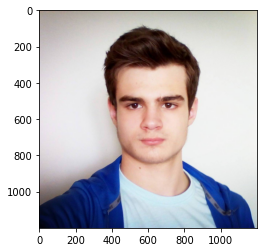

In [17]:
input.convert('RGB').resize((512, 512)).save('before.png', 'PNG')
plt.imshow(input)
plt.show()

[Text(0, -15, 'hair')]

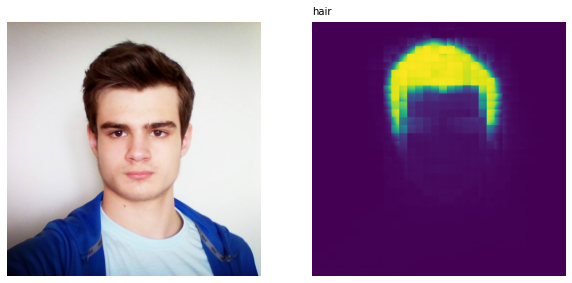

In [31]:
prompts = ['hair']
with torch.no_grad():
  preds = model(img.repeat(len(prompts), 1, 1, 1), prompts)[0]

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(10, 5))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input)
[ax[i + 1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))]
[ax[i + 1].text(0, -15, prompts[i]) for i in range(len(prompts))]

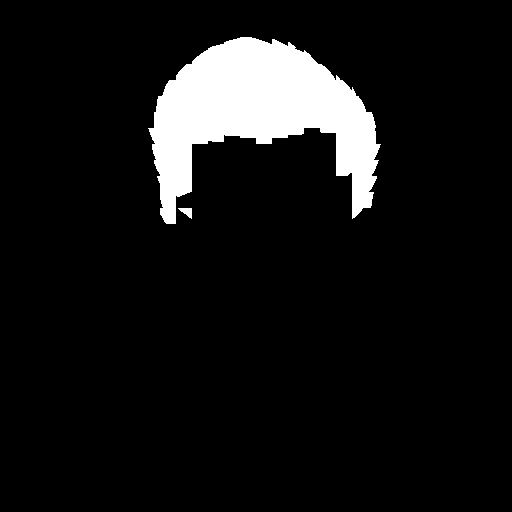

In [32]:
filename = 'mask.png'
plt.imsave(filename, torch.sigmoid(preds[0][0]))

img2 = cv2.imread(filename)
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
thresh, bw = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

cv2.imwrite(filename, bw)
cv2.cvtColor(bw, cv2.COLOR_BGR2RGB)
Image.fromarray(bw)

In [35]:
init_img = Image.open('before.png')
mask = Image.open('mask.png')

with autocast(device):
  images = pipe(prompt='curly blondie hair', 
                init_image=init_img, mask_image=mask, strength=0.8)['sample']

0it [00:00, ?it/s]

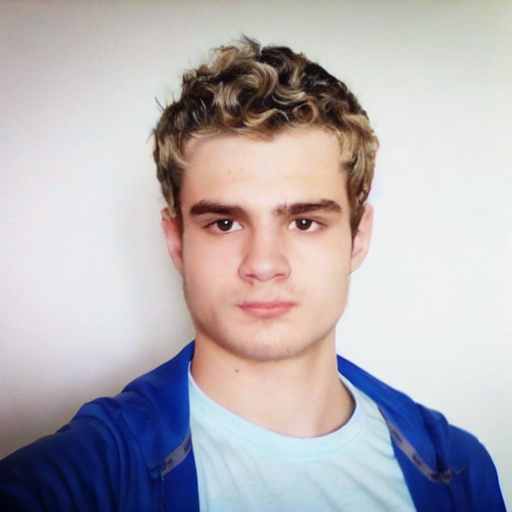

In [36]:
images[0]

[Text(0, -15, 'shirt'), Text(0, -15, 'hoodie')]

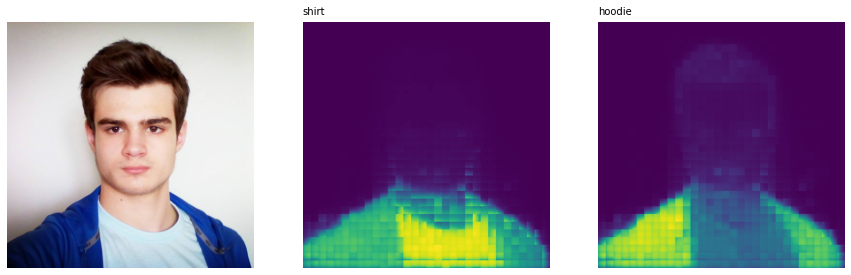

In [40]:
prompts = ['shirt', 'hoodie']
with torch.no_grad():
  preds = model(img.repeat(len(prompts), 1, 1, 1), prompts)[0]

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(15, 5))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input)
[ax[i + 1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))]
[ax[i + 1].text(0, -15, prompts[i]) for i in range(len(prompts))]

0it [00:00, ?it/s]

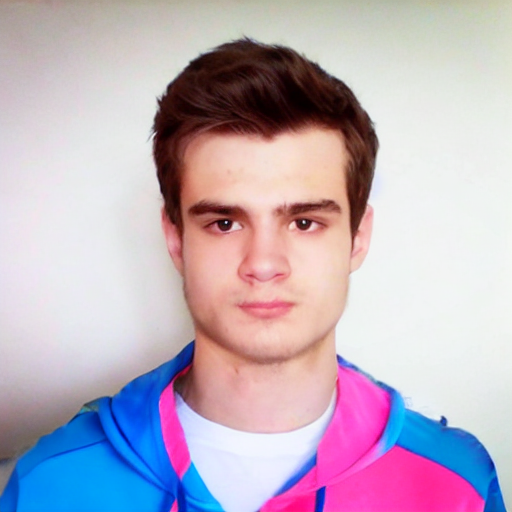

In [43]:
filename = 'mask.png'
plt.imsave(filename, torch.sigmoid(preds[0][0]))

img2 = cv2.imread(filename)
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
thresh, bw = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

cv2.imwrite(filename, bw)
cv2.cvtColor(bw, cv2.COLOR_BGR2RGB)
Image.fromarray(bw)

init_img = Image.open('before.png')
mask = Image.open('mask.png')

with autocast(device):
  images = pipe(prompt='a colorful hoodie', 
                init_image=init_img, mask_image=mask, strength=1.0)['sample']

images[0]